In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset with only 100 samples per class
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet-18 input size
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

#download the eurosat dataset
# train_dataset = torchvision.datasets.EuroSAT(root='./eurosat',  download=True, transform=transform)

random_seed = 42
torch.manual_seed(random_seed)

In [50]:
data_dir = 'EuroSAT/2750'
eurosat_dataset = datasets.ImageFolder(data_dir, transform=transform)
eurosat_dataset
# Split the data into train and test sets while preserving the original split

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: EuroSAT/2750
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [51]:
from torch.utils.data import DataLoader, random_split

total_size = len(eurosat_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    eurosat_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create DataLoader instances for train, validation, and test sets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

In [52]:
# ! pip install timm

In [64]:
import timm
vit_b12 = timm.create_model('vit_base_patch16_224', pretrained=True)

In [65]:
vit_b12

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [55]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

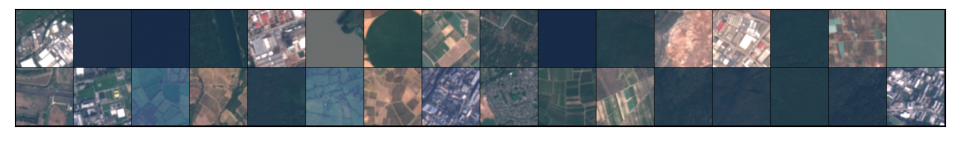

In [56]:
show_batch(train_loader)

In [66]:
# Define the ResNet-18 model
class EuroSAT_ViTBase12(nn.Module):
    def __init__(self):
        super(EuroSAT_ViTBase12, self).__init__()
        self.eurosat = vit_b12  # Initialize ResNet-18 without pretrained weights
        self.eurosat.head = nn.Linear(768, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.eurosat(x)

model = EuroSAT_ViTBase12()

# Loss and optimizer

In [78]:
model

EuroSAT_ViTBase12(
  (eurosat): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [69]:
model = model.to(device)

In [71]:
# Hyperparameters
num_epochs = 20
learning_rate = 1e-3

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [105]:
for param in model.parameters():
    param.requires_grad = False
    
model.eurosat.head.weight.requires_grad = True
model.eurosat.head.bias.requires_grad = True
# model.eurosat.norm.requires_grad=True

In [106]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")
    print(param.requires_grad)

Parameter name: eurosat.cls_token, Size: torch.Size([1, 1, 768])
False
Parameter name: eurosat.pos_embed, Size: torch.Size([1, 197, 768])
False
Parameter name: eurosat.patch_embed.proj.weight, Size: torch.Size([768, 3, 16, 16])
False
Parameter name: eurosat.patch_embed.proj.bias, Size: torch.Size([768])
False
Parameter name: eurosat.blocks.0.norm1.weight, Size: torch.Size([768])
False
Parameter name: eurosat.blocks.0.norm1.bias, Size: torch.Size([768])
False
Parameter name: eurosat.blocks.0.attn.qkv.weight, Size: torch.Size([2304, 768])
False
Parameter name: eurosat.blocks.0.attn.qkv.bias, Size: torch.Size([2304])
False
Parameter name: eurosat.blocks.0.attn.proj.weight, Size: torch.Size([768, 768])
False
Parameter name: eurosat.blocks.0.attn.proj.bias, Size: torch.Size([768])
False
Parameter name: eurosat.blocks.0.norm2.weight, Size: torch.Size([768])
False
Parameter name: eurosat.blocks.0.norm2.bias, Size: torch.Size([768])
False
Parameter name: eurosat.blocks.0.mlp.fc1.weight, Size: 

In [107]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if (i+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Average Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')

    #Validation stage
    model.eval()
    with torch.no_grad():
        val_loss=0
        val_correct = 0
        val_total = 0

        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
                    
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_avg_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Average Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
print('Training finished.')

Epoch [1/20], Train Average Loss: 1.1199, Train Accuracy: 59.85%
Epoch [1/20], Validation Average Loss: 1.0834, Validation Accuracy: 61.15%
Epoch [2/20], Train Average Loss: 1.0560, Train Accuracy: 62.13%
Epoch [2/20], Validation Average Loss: 1.0541, Validation Accuracy: 61.81%
Epoch [3/20], Train Average Loss: 1.0338, Train Accuracy: 63.00%
Epoch [3/20], Validation Average Loss: 1.0280, Validation Accuracy: 62.59%
Epoch [4/20], Train Average Loss: 1.0184, Train Accuracy: 63.52%
Epoch [4/20], Validation Average Loss: 1.0074, Validation Accuracy: 63.63%
Epoch [5/20], Train Average Loss: 1.0075, Train Accuracy: 63.70%
Epoch [5/20], Validation Average Loss: 0.9900, Validation Accuracy: 65.15%
Epoch [6/20], Train Average Loss: 0.9957, Train Accuracy: 64.32%
Epoch [6/20], Validation Average Loss: 1.0166, Validation Accuracy: 63.00%
Epoch [7/20], Train Average Loss: 0.9919, Train Accuracy: 64.28%
Epoch [7/20], Validation Average Loss: 0.9865, Validation Accuracy: 65.48%
Epoch [8/20], Train 

In [108]:
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

avg_loss_test = test_loss / len(test_loader)
accuracy_test = 100 * correct_test / total_test

In [109]:
print("Test accuracy: ",accuracy_test,"%", " Test Loss: ",avg_loss_test)

Test accuracy:  65.55555555555556 %  Test Loss:  0.9401124092035515


In [110]:
torch.save(model.state_dict(), 'eurosat-vit-base12-full_fine-tune.pth')